# Train a fully connected (dense) neural network for EMNIST Digits

This version will use some optimisation tricks to attempt to improve the results
- Batch training

In [31]:
using Flux
using MLUtils
using Statistics
using MLDatasets
using DataFrames
using OneHotArrays
using CairoMakie
using ProgressBars

## MNIST dataset

In [32]:
train_data = MNIST(split = :train)
test_data = MNIST(split = :test)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

### Data Exploration and Visualisation

Note this version of the dataset uses floats in the range [0,1] for the pixel intensity, data features are a 28x28 array. Labels are simple integers.

## Network Definition

We define a network that takes the 28x28 input image array (vector of 784), passes it through two hidden layers of 1000 neurons, then the output layer is 10 neurons, passed through softmax.

In [33]:
dense_model = Chain(
    Dense(28 * 28, 1000, relu),
    Dense(1000, 1000, relu),
    Dense(1000, 10),
    softmax
)

Chain(
  Dense(784 => 1000, relu),             # 785_000 parameters
  Dense(1000 => 1000, relu),            # 1_001_000 parameters
  Dense(1000 => 10),                    # 10_010 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 1_796_010 parameters, 6.852 MiB.

In [34]:
const classes = sort(unique(train_data.targets));

In [35]:
train_y = onehotbatch(train_data.targets, classes);
test_y = onehotbatch(test_data.targets, classes);

In [36]:
train_x = reshape(train_data.features, (28 * 28, size(train_data.features, 3)));
test_x = reshape(test_data.features, (28 * 28, size(test_data.features, 3)));

In [37]:
# Define a tuple with the data and features (Flux wants this format)
train_dataset = [(train_x, train_y)];
test_dataset = [(test_x, test_y)];

In [38]:
"""
    measure_loss(model, features, labels_onehot)

Calculate the loss for a Flux model given the features and one-hot encoded labels.
"""
function measure_loss(model, features, labels_onehot)
    ŷ = model(features)
    Flux.logitcrossentropy(ŷ, labels_onehot)
end;

In [39]:
"""
    measure_accuracy(x, y)

Calculate the accuracy of the model predictions against the true labels.
"""
measure_accuracy(x, y) = mean(Flux.onecold(dense_model(x), classes) .== y);

## Training Loops

Here we will train using batched data, so the model will update after each training batch

In [40]:
batchsize = 1000
array_loader = DataLoader(train_dataset[1]; batchsize=batchsize, shuffle=true);

### Calling Conventions

In [41]:
# This syntax works - take each piece of the array loader and pass it to the model
# as a batch of data.
# for e in array_loader
#     Flux.train!(dense_model, [e], opt_state) do m, x, y
#         measure_loss(m, x, y)
#     end
# end

# This syntax also works - here train!() is called with the entire array loader
# and the model is trained on each batch of data in the loader.
# Flux.train!(dense_model, array_loader, opt_state) do m, x, y
#     measure_loss(m, x, y)
# end

### Loop using `train!`

In [42]:
opt_state = Flux.setup(Adam(), dense_model);

In [43]:
# Now run for a decent number of epochs
epochs = 40
accuracy = Vector{Float32}()
push!(accuracy, measure_accuracy(train_x, train_data.targets))
test_accuracy = Vector{Float32}()
push!(test_accuracy, measure_accuracy(test_x, test_data.targets))
loss = Vector{Float32}()
push!(loss, measure_loss(dense_model, train_x, train_y))
start = time()
for i in 1:epochs
    Flux.train!(dense_model, array_loader, opt_state) do m, x, y
        measure_loss(m, x, y)
    end
    acc = measure_accuracy(train_x, train_data.targets)
    push!(accuracy, acc)
    test_acc = measure_accuracy(test_x, test_data.targets)
    push!(test_accuracy, test_acc)
    l = measure_loss(dense_model, train_x, train_y)
    push!(loss, l)
    if i % 5 == 0
        elapsed = time() - start
        println("Accuracy after epoch $i: $acc (train), $test_acc (test); loss: $l; $(round(elapsed, digits=2))s ($(round(elapsed / i, digits=2))s/epoch)")
    end
end


Accuracy after epoch 5: 0.9802166666666666 (train), 0.9712 (test); loss: 1.4826415; 17.6s (3.52s/epoch)
Accuracy after epoch 10: 0.9914 (train), 0.98 (test); loss: 1.4707203; 34.83s (3.48s/epoch)
Accuracy after epoch 15: 0.994 (train), 0.9816 (test); loss: 1.4677055; 51.83s (3.46s/epoch)
Accuracy after epoch 20: 0.9950166666666667 (train), 0.9822 (test); loss: 1.4664469; 68.67s (3.43s/epoch)
Accuracy after epoch 25: 0.9948333333333333 (train), 0.9799 (test); loss: 1.4667914; 85.62s (3.42s/epoch)
Accuracy after epoch 30: 0.99645 (train), 0.9833 (test); loss: 1.4647948; 102.21s (3.41s/epoch)
Accuracy after epoch 35: 0.9962 (train), 0.9825 (test); loss: 1.4651693; 118.61s (3.39s/epoch)
Accuracy after epoch 40: 0.9962 (train), 0.9819 (test); loss: 1.4650612; 135.17s (3.38s/epoch)


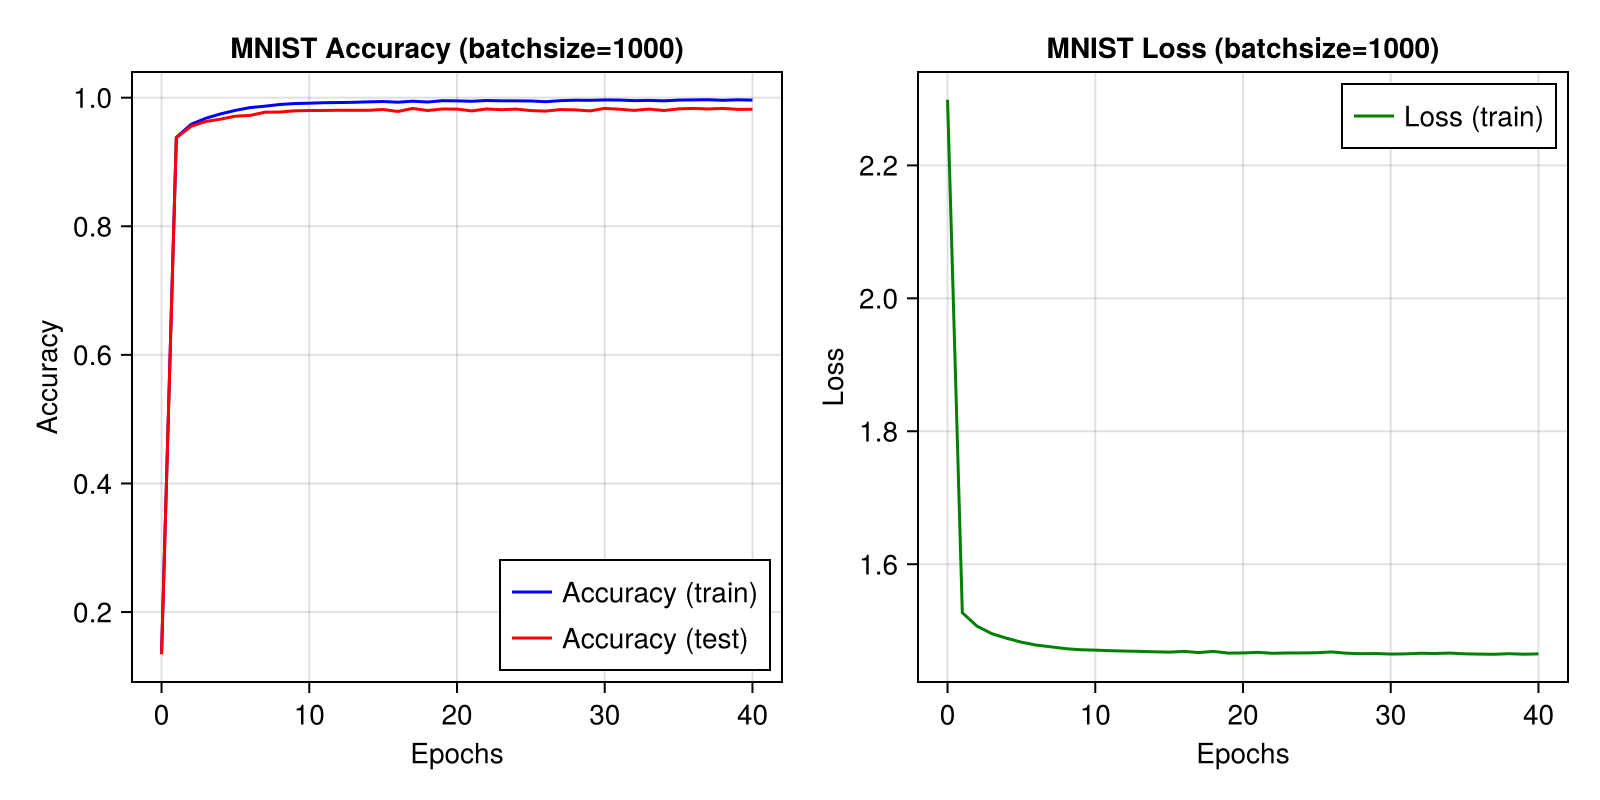

In [44]:
let 
    f = Figure(size=(800, 400))
    epochs = collect(0:length(accuracy)-1)
    ax_acc = Axis(f[1, 1],
        title = "MNIST Accuracy (batchsize=$(batchsize))",
        xlabel = "Epochs",
        ylabel = "Accuracy",)
    lines!(ax_acc, epochs, accuracy, label = "Accuracy (train)", color = :blue)
    lines!(ax_acc, epochs, test_accuracy, label = "Accuracy (test)", color = :red)
    axislegend(position = :rb)
    ax_loss = Axis(f[1, 2],
        title = "MNIST Loss (batchsize=$(batchsize))",
        xlabel = "Epochs",
        ylabel = "Loss",)
    lines!(ax_loss, epochs, loss, label = "Loss (train)", color = :green)
    axislegend(position = :rt)
    save(joinpath("plots", "mnist-batch-$(batchsize).png"), f)
    f
end